In [1]:
from __future__ import print_function
import pickle
import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import l2
from keras import backend as K
from google.colab import drive

batch_size = 30
num_classes = 10
epochs = 20
num_training_samples = 6000
num_test_samples = 1000

img_rows, img_cols = 28, 28

class MnistUtil:
  def __init__(self):
    self.data = None
    self.model = None

  def init_data(self):
    # input image dimensions
    img_rows, img_cols = 28, 28

    # the data, split between train and test sets
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    training_samples = np.random.choice(np.arange(x_train.shape[0]), num_training_samples, replace=False)
    x_train, y_train = x_train[training_samples], y_train[training_samples]

    test_ind = np.random.choice(np.arange(x_test.shape[0]), num_test_samples, replace=False)
    x_test, y_test = x_test[test_ind], y_test[test_ind]
    
    self.data = (x_train, y_train, x_test, y_test)
    
  def get_data(self):
    if self.data is None:
      self.init_data()
    return self.data
  
  def get_augmented_test_data(self, rotation=0.0, blur=0.0):
    def transform(image):
      return np.asarray(Image.fromarray(image).rotate(rotation).filter(ImageFilter.GaussianBlur(blur)))
      
    if self.data is None:
      self.init_data()
      
    x_train, y_train, x_test, y_test = self.data

    x_test_transformed = []
    
    for x_ts in x_test:
      x_test_transformed.append(transform(x_ts))
      
    x_test_transformed = np.asarray(x_test_transformed)
      
    return (x_train, y_train, x_test_transformed, y_test)
    

class VGG11:
  def __init__(self):
    self.history = None
    self.results = dict()
    
  def process_data(self, data):
    x_train, y_train, x_test, y_test = data
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    
    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    return (x_train, y_train, x_test, y_test)

  def construct_model(self, input_shape, regularizer=None):
    layers = [
        # add padding
        ZeroPadding2D((2, 2), input_shape=input_shape),
        # block 1
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizer),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
        # block 2
        Conv2D(128, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizer),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
        # block 3
        Conv2D(256, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizer),
        Conv2D(256, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizer),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
        # block 4
        Conv2D(512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizer),
        Conv2D(512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizer),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
        # block 5
        Conv2D(512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizer),
        Conv2D(512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizer),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
        # top layers
        Flatten(),
        Dense(4096, activation='relu', kernel_regularizer=regularizer),
        Dense(4096, activation='relu', kernel_regularizer=regularizer),
        Dense(1000, activation='relu', kernel_regularizer=regularizer),
        Dense(num_classes, activation='softmax', kernel_regularizer=regularizer)
    ]
    
    model = Sequential()

    for layer in layers:
      model.add(layer)
      
    sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=sgd,
                  metrics=['accuracy'])

    return model
  
  def train(self, data, regularizer=None):
    # data is a four tuple of (x_train, y_train, x_test, y_test)
    (x_train, y_train, x_test, y_test) = self.process_data(data)
    model = self.construct_model(x_train[0].shape, regularizer)

    self.history = model.fit(x_train, y_train,
                             batch_size=batch_size,
                             epochs=epochs,
                             validation_data=(x_test, y_test),
                             verbose=1)

    self.model = model
    
  def train_augmented(self, data):
    (x_train, y_train, x_test, y_test) = self.process_data(data)
    model = self.construct_model(x_train[0].shape)

    datagen = ImageDataGenerator(rotation_range=45,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.1,
                                zoom_range=0.15,
                                horizontal_flip=False,
                                vertical_flip=False)
    
    datagen.fit(x_train)
    
    self.history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                                     steps_per_epoch=x_train.shape[0] // batch_size,
                                     epochs=epochs,
                                     verbose=1,
                                     validation_data=(x_test, y_test))
    
    self.model = model

    
  def evaluate(self, identifier, data):
    (x_train, y_train, x_test, y_test) = self.process_data(data)
    score = self.model.evaluate(x_test, y_test, verbose=0)
    self.results[identifier] = score

Using TensorFlow backend.


In [0]:
if __name__ == '__main__':
  mnist_util = MnistUtil()
  vgg11 = VGG11()
  data = mnist_util.get_data()
  vgg11.train(data)
  
  vgg11_reg = VGG11()
  l2_regularizer = l2(5 * (10 ** -4))
  vgg11_reg.train(data, regularizer=l2_regularizer)

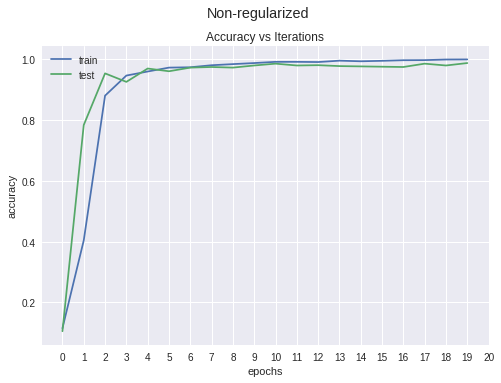

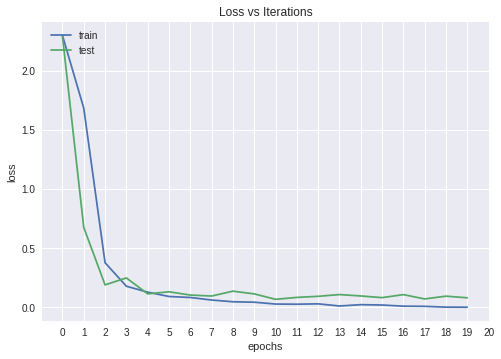

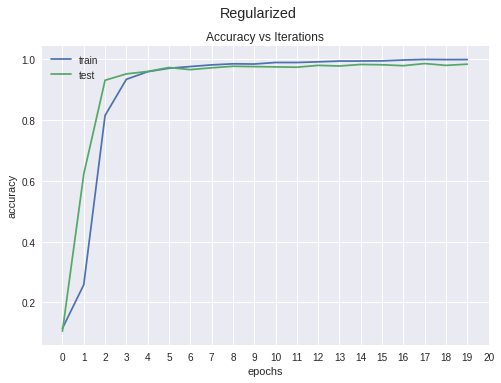

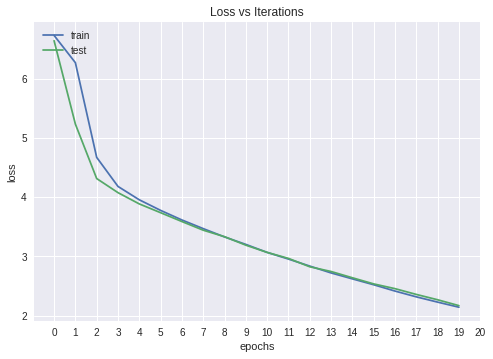

In [4]:
# plot test and training info

def plot_history(history, title):
  figure = plt.figure()
  figure.suptitle(title)
  
  plt.plot(history['acc'])
  plt.plot(history['val_acc'])
  plt.title('Accuracy vs Iterations')
  plt.ylabel('accuracy')
  plt.xlabel('epochs')
  plt.legend(['train', 'test'], loc='upper left')
  plt.xticks(np.arange(0, epochs+1, 1))
  plt.show()
  
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title('Loss vs Iterations')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend(['train', 'test'], loc='upper left')
  plt.xticks(np.arange(0, epochs+1, 1))
  plt.show()

  
plot_history(vgg11.history.history, 'Non-regularized')
plot_history(vgg11_reg.history.history, 'Regularized')

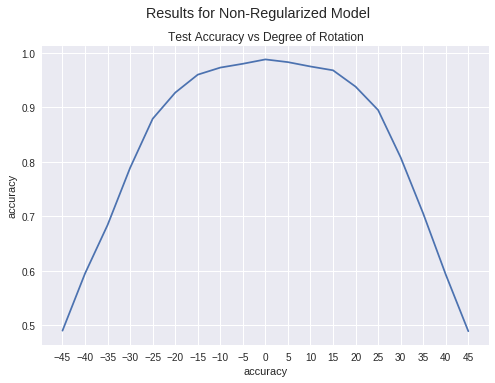

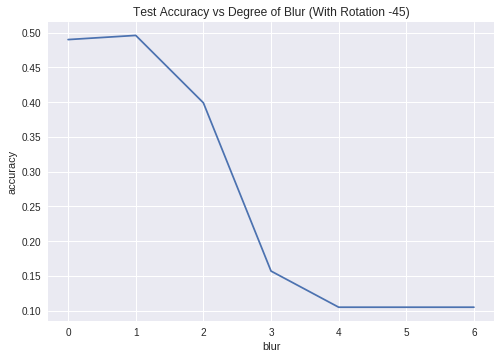

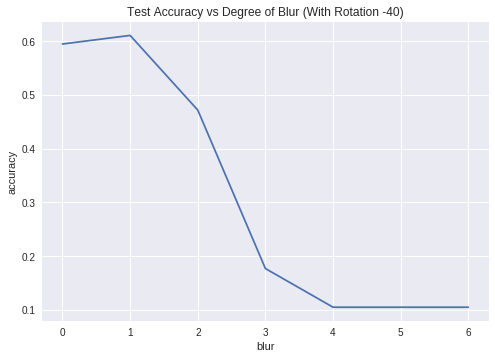

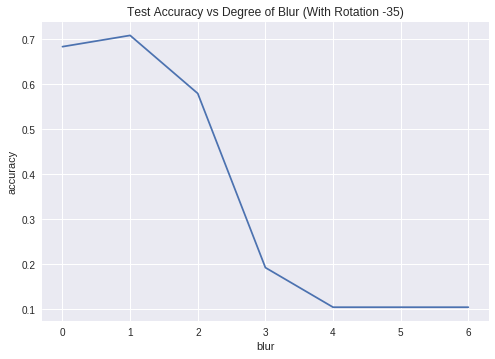

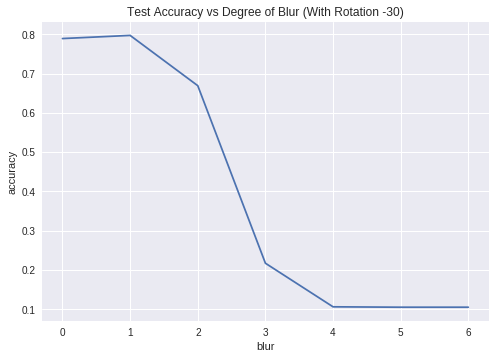

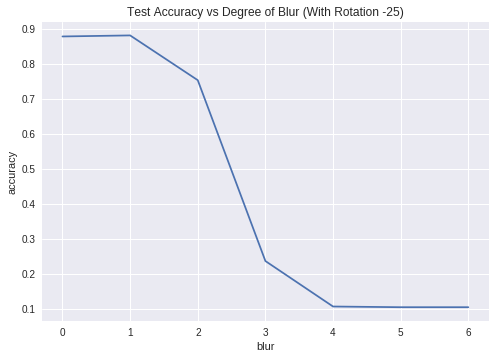

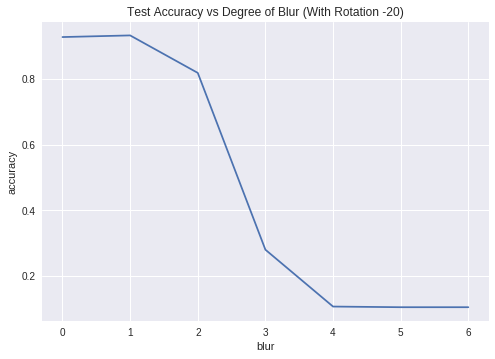

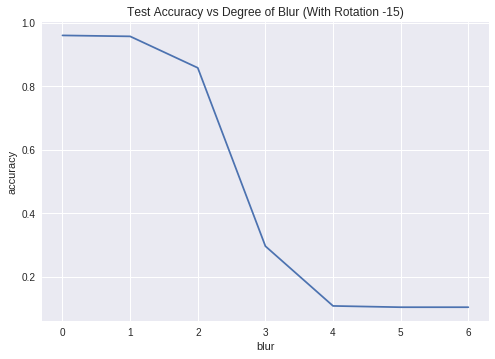

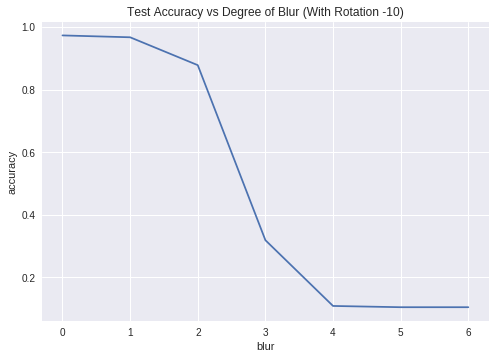

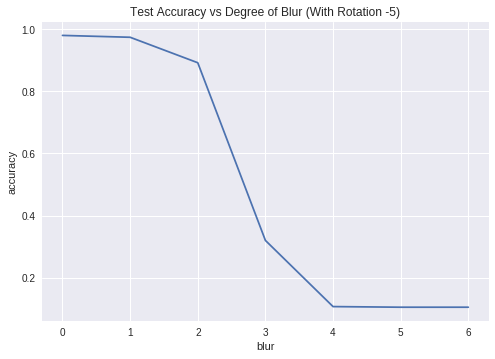

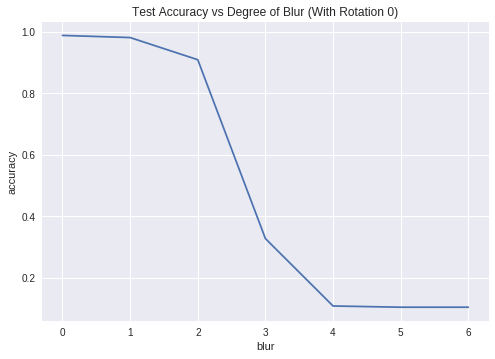

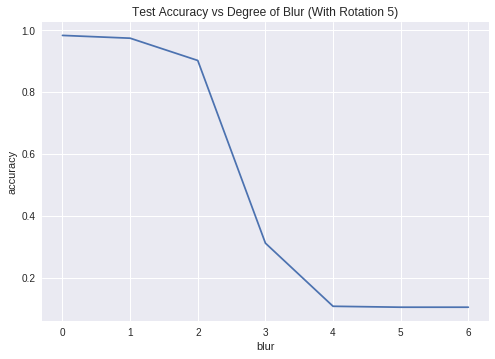

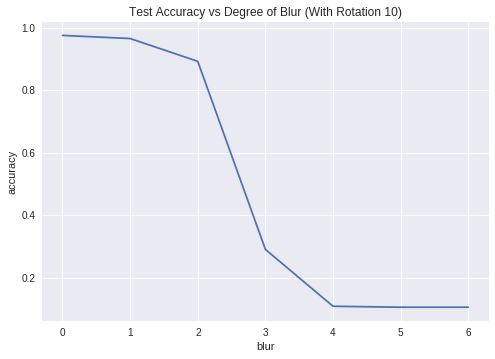

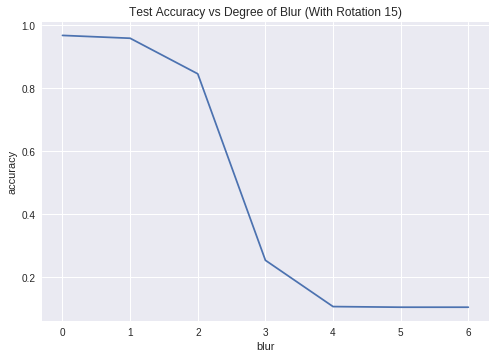

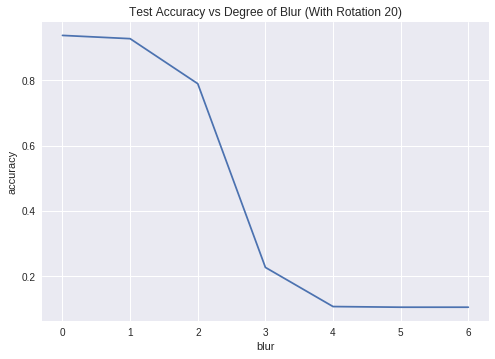

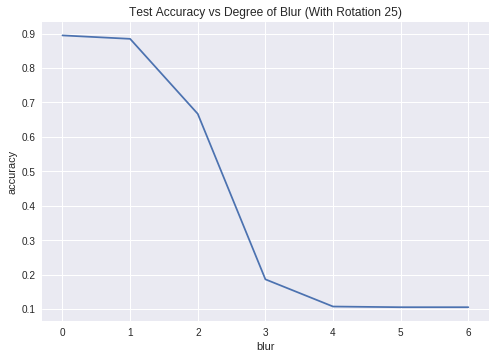

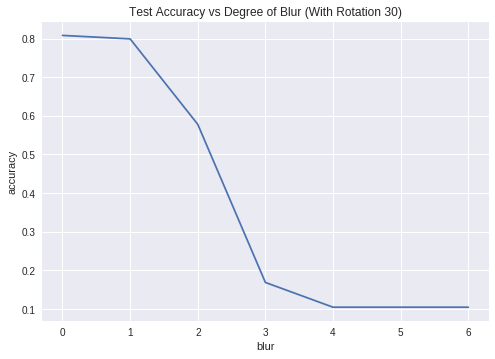

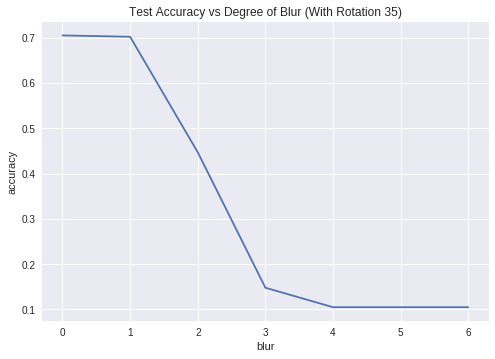

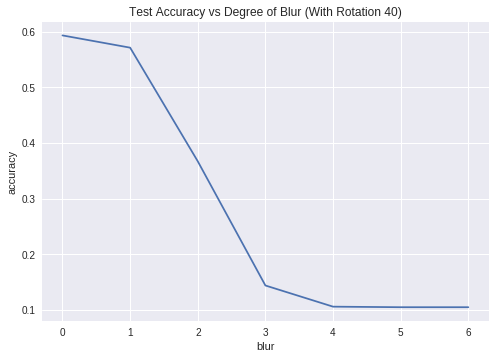

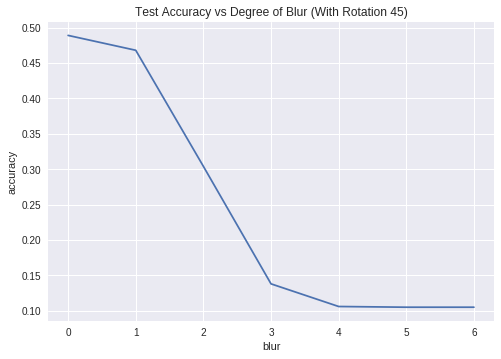

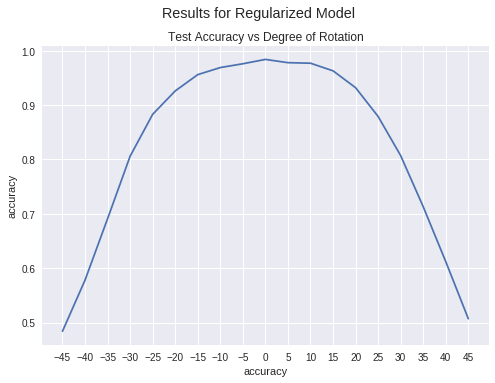

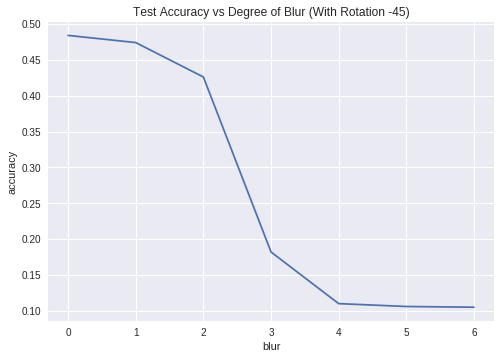

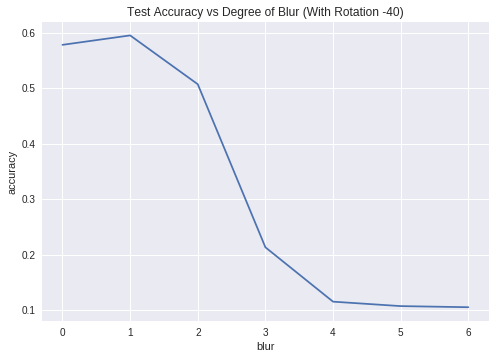

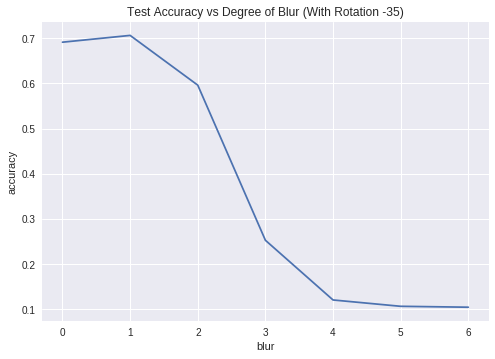

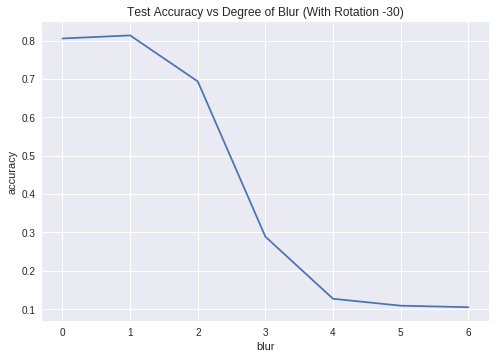

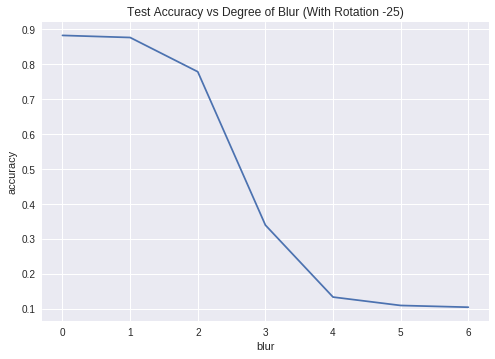

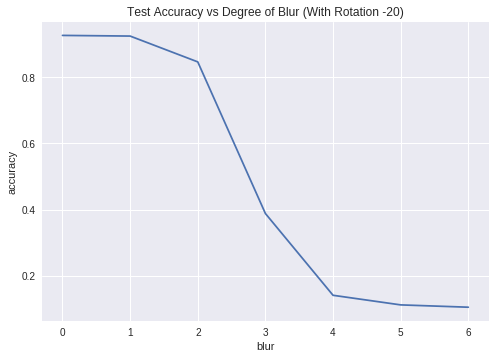

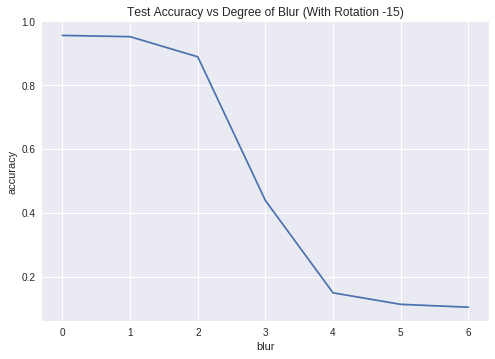

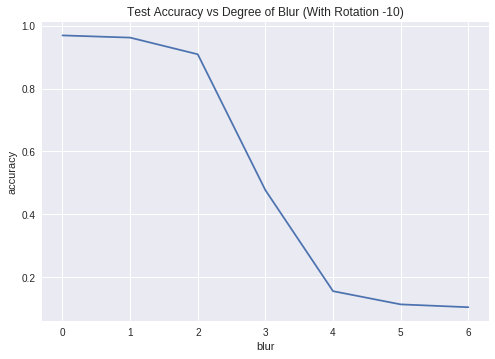

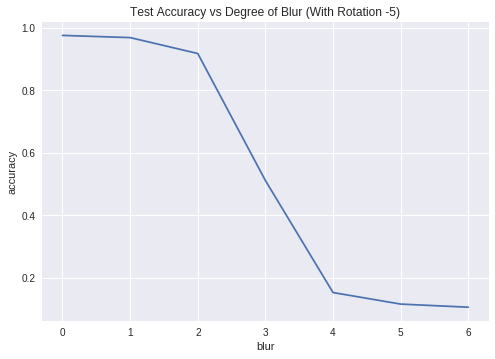

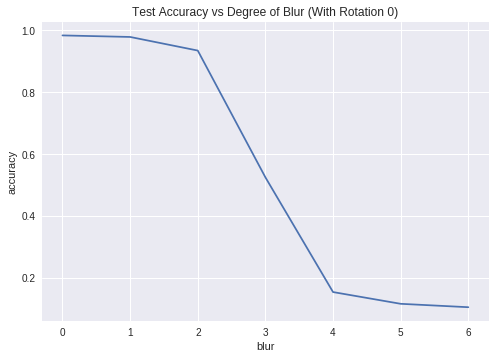

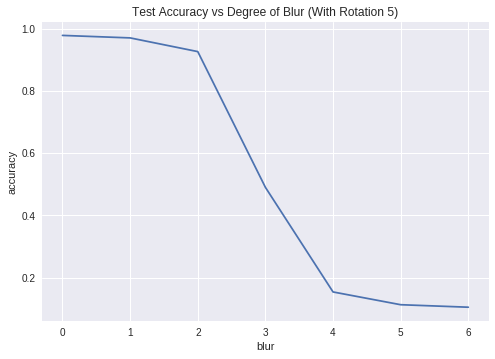

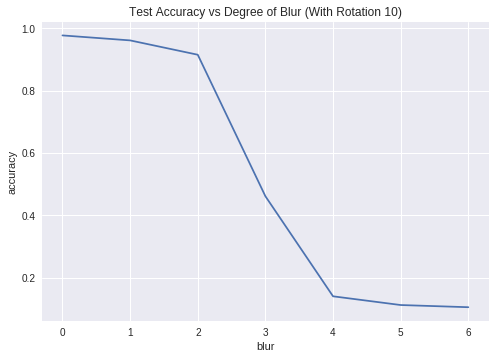

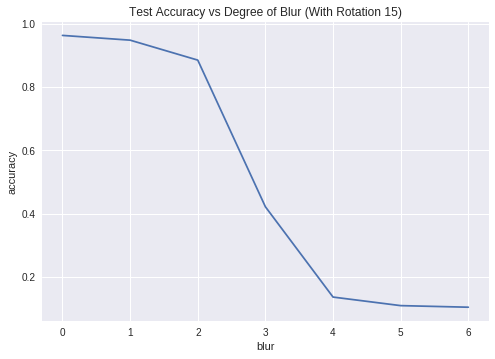

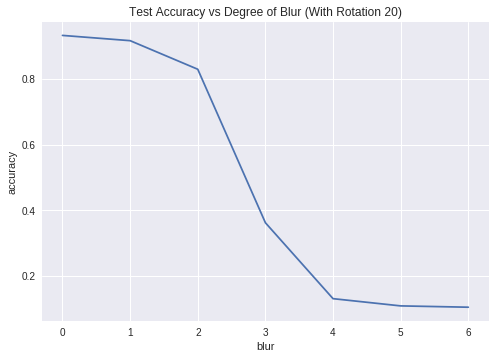

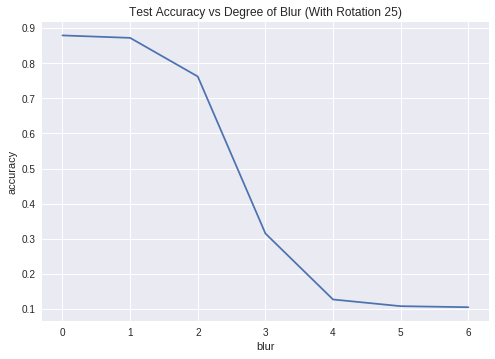

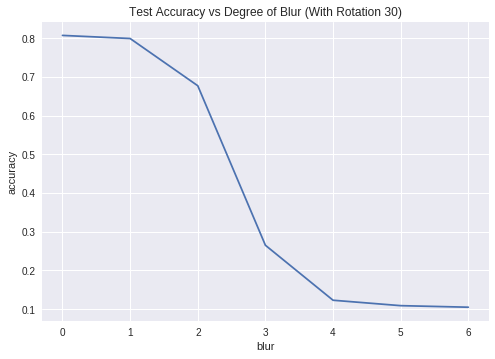

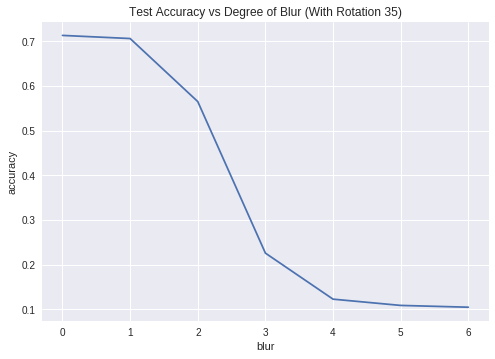

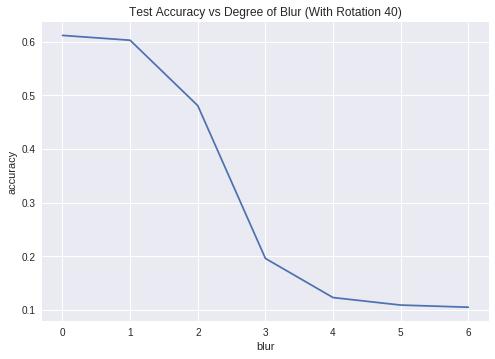

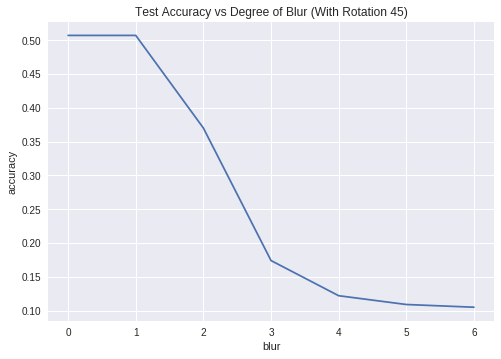

In [5]:
# Plot accuracies for rotations and blurs, both for regularized and non-regularized

rotations = np.arange(-45, 46, 5)
blurs = np.arange(7)

def get_key(rotation, blur):
  return 'rotation_' + str(rotation) + '_blur_' + str(blur)

def evaluate_model(vgg_model):
  for rotation in rotations:
    for blur in blurs:
      aug_test_data = mnist_util.get_augmented_test_data(rotation=rotation, blur=blur)
      vgg_model.evaluate(get_key(rotation, blur), aug_test_data)

def plot_results(results, title):
  figure = plt.figure()
  figure.suptitle(title)
  
  rotation_results = []
  for rotation in rotations:
    accuracy = results[get_key(rotation, 0)][1]
    rotation_results.append(accuracy)

  plt.plot(rotations, rotation_results)
  plt.title('Test Accuracy vs Degree of Rotation')
  plt.ylabel('accuracy')
  plt.xlabel('accuracy')
  plt.xticks(rotations)
  plt.show()

  for rotation in rotations:
    blur_results = []
    for blur in blurs:
      accuracy = results[get_key(rotation, blur)][1]
      blur_results.append(accuracy)
    plt.plot(blurs, blur_results)
    plt.title('Test Accuracy vs Degree of Blur (With Rotation %d)' % rotation)
    plt.ylabel('accuracy')
    plt.xlabel('blur')
    plt.xticks(blurs)
    plt.show()
    
evaluate_model(vgg11)
evaluate_model(vgg11_reg)

plot_results(vgg11.results, 'Results for Non-Regularized Model')
plot_results(vgg11_reg.results, 'Results for Regularized Model')

### Effect of rotation:
The test accuracy decreases as the degree of rotation increases.

### Effect of blurring:
Blurring the images also causes a reduction in test accuracy.

### Effect of regularization:
With the L2 regularization, the model becomes harder to train but generalizes better, as can be seen in the plots above.

Regularization constant: 5 * (10 ** -4)

In [0]:
# data augmentation

from keras.preprocessing.image import ImageDataGenerator

mnist_util = MnistUtil()
data = mnist_util.get_data()
vgg11_aug = VGG11()
vgg11_aug.train_augmented(data)

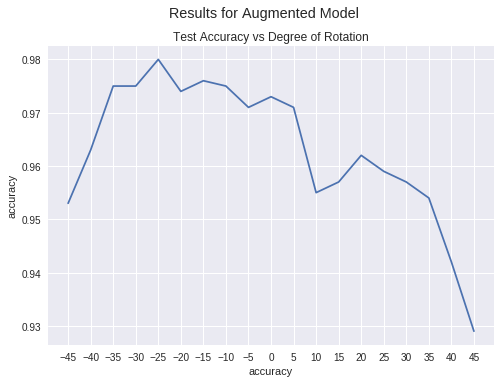

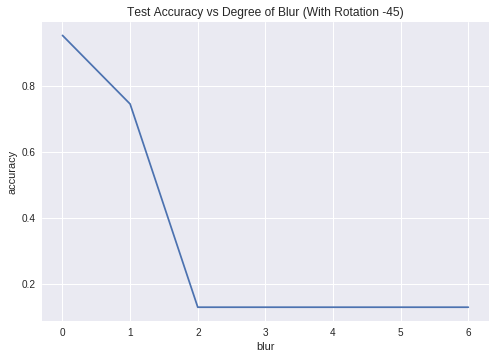

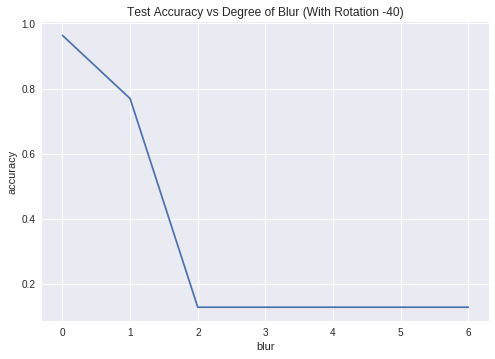

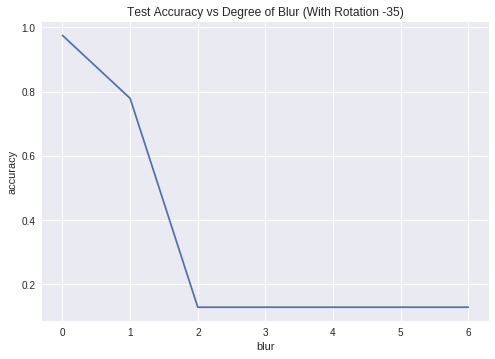

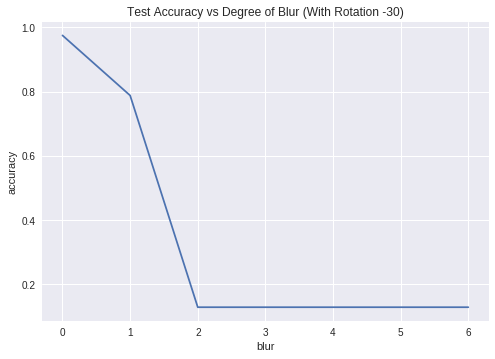

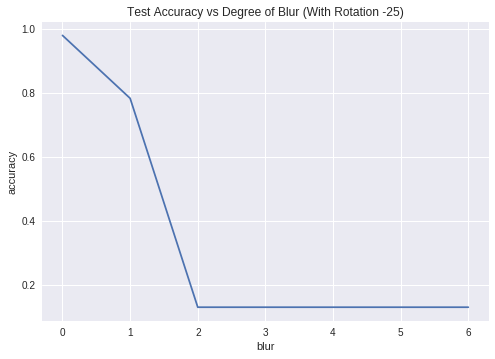

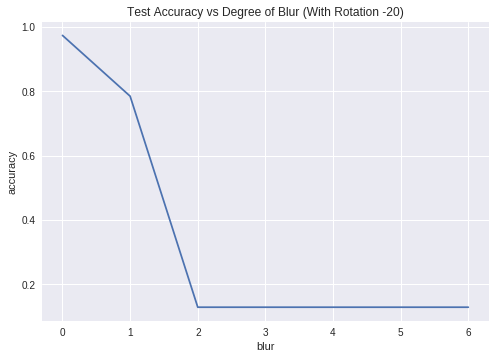

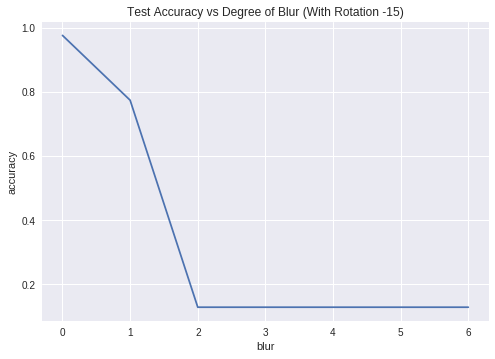

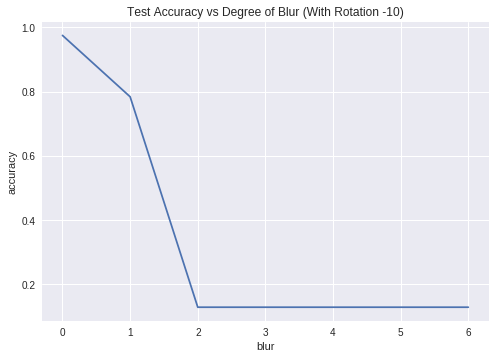

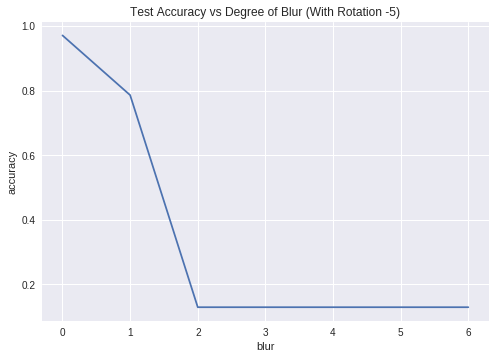

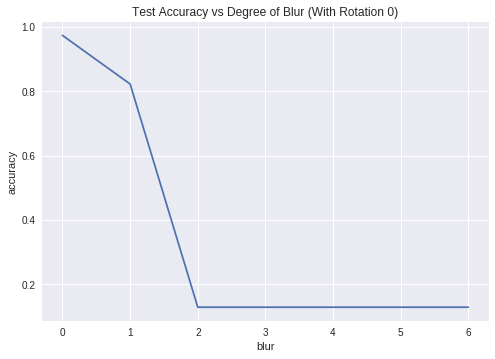

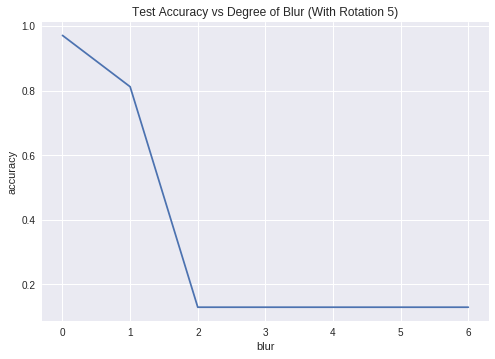

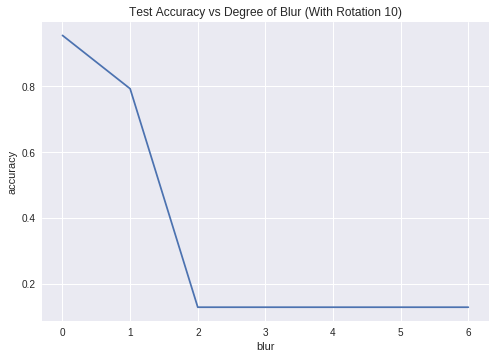

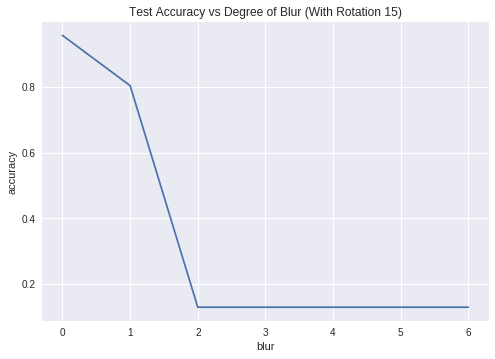

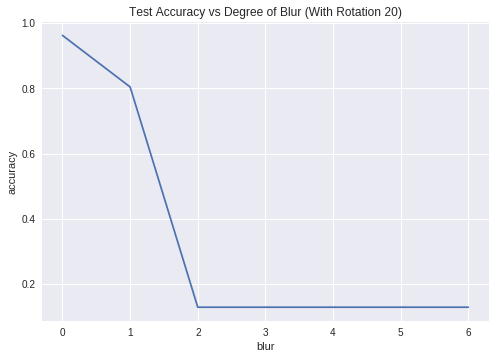

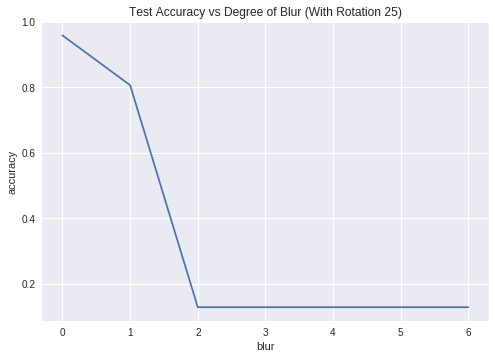

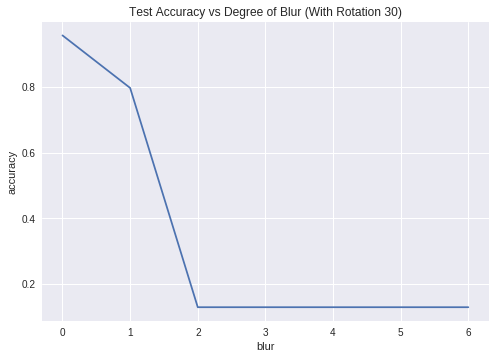

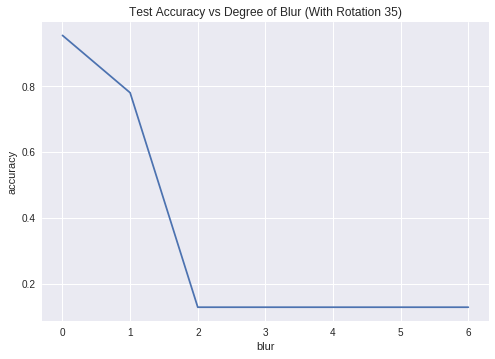

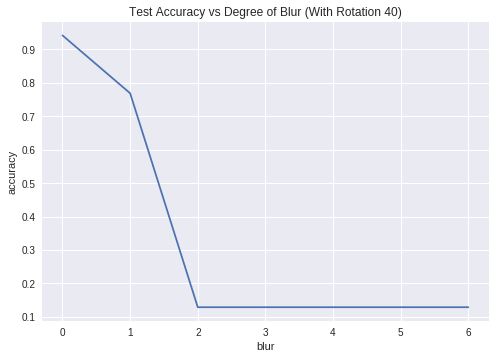

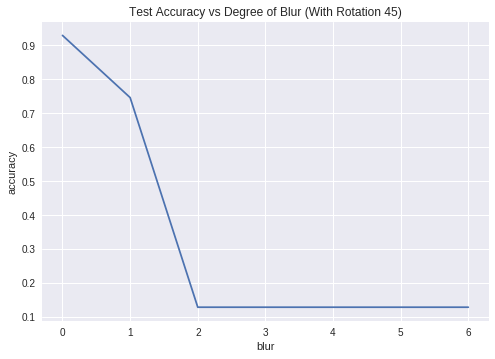

In [7]:
evaluate_model(vgg11_aug)
plot_results(vgg11_aug.results, 'Results for Augmented Model')

I used an augmentation that is similar to the one mentioned [here](https://blog.novatec-gmbh.de/keras-data-augmentation-for-cnn/) by fine-tuning the parameters for our dataset.